# Replicating Axelrod1997: Social influence model

Samuli Reijula, 2022-07-14


the original: "the model is coded in Pascal. Running on Macintosh Quadra 700"

In [ ]:
# imports

import random

## reading the paper

* agents don't move 
* q: if interaction makes people more similar, why don't all differences disappear?
* 'culture': set of attributes that people influence others over 
* q: how does culture get sustained?
* --> there are several existing explanations, this model provides a new one 
* theoretical premise: transfer of ideas occurs most frequently between people who are similar 
    * (SR: homophily)

* comparison to existing models: they treat every feature of culture as independent


### assumptions of the model
* interactions more likely to occur between people who are similar
* for each **feature**, there is a set of **traits**, alternative values of the feature
* **culture** described as a list of digits 
* cultural similarity: percentage of shared traits 
* geographic setting: static villages on a 10 x 10 grid 
* interaction: each site can only interact only with its immediate neighbors 
    * central sites of the terrain have 4 neighbors 
    * sides only 3
    * corners 2
* dynamics:
    * step 1: randomly pick a site and its random neighbor 
    * step 2: these interact with a probability equal to their cultural similarity:
        * choose randomly a feature on which the site and its neighbor differ (if such a feature exists) 
        * change site's trait to the same as the neighbor has
* run up to 80000 time steps
* **cultural region**: a set of contiguous sites with identical cultures 
* number of replications for each territory size: 40
* **cultural zone**: set of contiguous sites that could interact (= share at least 1 trait)

### findings
* questions about the model
    * does it converge? if yes, to what? how long does it take?
    * how many stable regions there are? 
    
* findings
    * the model converges when for each cell, it's neighbors are either identical or completely different 
        * there are only **stable regions**
    * as a simulation run proceeds, the number of regions decreases 
    * see table 2, can we replicate those findings?
    * as the number of features increases, so does the likelihood of complete cultural convergence 
    * as the number of traits increases, the number of stable regions increases

### variations and extensions of the model
* variation (a): larger neighborhood, also corners included --> 8 neighbors 
* variation (b): diamond neighborhood, add to (a) distance 2 sites in cardinal directions 
* findings 
    * larger neighborhoods result in fewer stable regions 
* variation (c): 5 x 5 grid 
* variation (d): 15 x 15 grid 
* eventually up to (100 x 100)
* variation (e): wrap territory
    
* all combinations of (a-b) * (c-d) tested in the original paper

* findings
    * interesting interactions between parameters, see p. 214-215
    * read 215 --> 
    
* suggested extensions 
    * cultural drift (spontaneous change in a trait)
    * terrain effects (some sites less probably to interact)
    * early geographical differences (nonrandom individual traits) 
    * status (some sites less likely to change than others)
    * cultural attractiveness (some traits less likely to change than others)
    * technological change (continuing introduction of new traits)
    * material basis for culture (interaction between trait attractiveness and terrain)
    * public education and broadcasting (some interactions come from widely disseminated messages)
    * mobility
    * organizational culture (substituting hierarchical for geographic neighborhoods)
    * sociology of science (interaction between semi-isolated disciplines with drift, technological change, and organizational culture)
    * cultural divergence (interaction between dissimilar sites causing greater cultural distance)

# Replication of the model

## todo / ideas
* derive cultural similarity matrix (size agents*agents)

In [ ]:
# parameters

FEATURES = 5             #5 # 10, 15
TRAITS = 10               # 5 # 10, 15
TERRITORY_SIZE = 10      # 10
REPS_PER_TERRITORY = 500 # 40 
MAX_TIME =  80000        # 10000 --> 80000

In [ ]:
class Territory():
    """
    an instance of the class 'Territory' has two properties: 
    * size
    * grid: an array where each cell contains the feature vector of the respective agent
    """
    
    def __init__( self , size ):
        self.size = size
        self.grid = [ [0 for y in range( self.size )] for x in range( self.size ) ] # initializing a 2-dim array in pure python (i.e. without numpy) 


### TESTS ###
t = Territory( size=3 ) # creates an instance of the class 'Territory', territory size given as a parameter
print('the grid:' , t.grid)

the grid: [[0, 0, 0], [0, 0, 0], [0, 0, 0]]


In [ ]:
class Agent():
    """
    an Agent has three properties:
    * feature vector
    * position
    * list of references to neighbors
    """
    
    def __init__( self , features , traits ):
        self.feature_vector = [ random.randint( 0 , traits ) for x in range( features ) ] # initialize an agent with a random culture vector
        self.position = [0,0] # to be set later
        self.neighbors = []
    
    
    def __str__( self ):
        """
        when defined, a __str__ function of a class allows printing an instance of a class
        (you get to decide what information gets printed)
        """
        return str( self.feature_vector )
        
        
### TESTS ###
a = Agent( FEATURES , TRAITS ) # create a random agent 
print(a) # print its culture


[3, 10, 5, 7, 10]


In [ ]:
class Population():
    
    def __init__( self , territory , features , traits ):
        """
        when creating a Population, you pass to it a reference to a Territory, as well as the number of features 
        in the culture and the number of traits per feature
        """
        self.agents = [] # this list will hold references to all agents on the grid 
        self.territory = territory
        
        # place a random agent in each grid position 
        for y in range( territory.size ):
            for x in range( territory.size ):
                a = Agent( features , traits )
                a.position = [ x , y ]
                territory.grid[x][y] = a
                self.agents.append( a )
                #print(territory.grid[x][y] , a)

        # find each agent's neighbors 
        for focal_agent in self.agents:
            focal_x = focal_agent.position[0]
            focal_y = focal_agent.position[1]
            neighborhood_positions = [ (-1,0) , (1,0) , (0,-1) , (0,1) ] # the von Neumann neighborhood around (0,0)
            for n in neighborhood_positions:
                    neighbor_x = focal_x + n[0]
                    neighbor_y = focal_y + n[1]
                    
                    # make sure we're still on the grid
                    # if yes, add a reference to the neighbor in the focal agent's list of neighbors
                    if (neighbor_x >= 0 and neighbor_x <= (territory.size-1)) and \
                       (neighbor_y >= 0 and neighbor_y <= (territory.size-1)):
                        focal_agent.neighbors.append( territory.grid[neighbor_x][neighbor_y] )
                    #print(neighbor_x, neighbor_y , focal_agent.neighbors)
    
    
    def similarity( agent1 , agent2 ):
        """
        if the equals operator returns a True, this is treated as a 1. 
        The 1's can be summed, and this gives a handy way to count the proportion of identical traits between 
        two agents
        """
        return sum([(agent1.feature_vector[i] == agent2.feature_vector[i]) for i in range(FEATURES)])/(FEATURES*1.0)
        
        # NOTE: multiplication by 1.0 makes sure we're using real numbers, not integers for the division
        
    
#    def identical( agent1 , agent2):
#        """
#        return True if two agents have the same feature vector
#        """
#        return agent1.feature_vector == agent2.feature_vector
    
    
    def adopt_trait( receiver , giver ):
        """
        1. choose randomly a feature where the agent and its neighbor differ 
        2. change agent's trait to the same as the neighbor has
        """
        #print(receiver)
        #print(giver)
        
        found = False
        while not found:
            i = random.randint( 0 , FEATURES-1 )
            found = ( receiver.feature_vector[i] != giver.feature_vector[i] ) # found is True if the traits are *not* the same
        
        receiver.feature_vector[i] = giver.feature_vector[i]
        #print()
        #print(receiver)
        #print(giver)
            
            
    def unique_cultures( self ):
        """
        returns the list of unique cultures in the population
        """
        culture_list = []
        for a in self.agents:
            if a.feature_vector not in culture_list:
                culture_list.append( a.feature_vector )
        return culture_list 
        
        
### TESTS ###

a = Agent( FEATURES , TRAITS )
#a.feature_vector = [1,1,1,1,1]
print('agent a:' , a)

b = Agent( FEATURES , TRAITS )
#b.feature_vector = [1,1,1,1,1]

print('agent b:' , b)
print('similarity:' , Population.similarity( a , b ))
print()
            
if not Population.similarity(a , b) == 1.0:
    Population.adopt_trait(a , b)

print('a:', a)
print('b:', b)
print('similarity:', Population.similarity( a , b))
print()


print('a 3x3 grid with a random population:')
p = Population( Territory( 3 ) , FEATURES , TRAITS )
for i in p.agents:
    nlist = []
    for n in i.neighbors:
        nlist.append( n.position )
        
    print('position: ' , i.position ,'\t', 'feature vector: ' ,'\t', i.feature_vector ,'\t', 'neighbors: ' , nlist)

print()
print( 'unique cultures in the population: ' , p.unique_cultures() )

agent a: [10, 3, 1, 6, 7]
agent b: [6, 1, 4, 2, 8]
similarity: 0.0

a: [10, 3, 1, 2, 7]
b: [6, 1, 4, 2, 8]
similarity: 0.2

a 3x3 grid with a random population:
position:  [0, 0] 	 feature vector:  	 [0, 9, 10, 0, 7] 	 neighbors:  [[1, 0], [0, 1]]
position:  [1, 0] 	 feature vector:  	 [4, 7, 0, 0, 8] 	 neighbors:  [[0, 0], [2, 0], [1, 1]]
position:  [2, 0] 	 feature vector:  	 [5, 8, 10, 10, 3] 	 neighbors:  [[1, 0], [2, 1]]
position:  [0, 1] 	 feature vector:  	 [0, 10, 4, 9, 6] 	 neighbors:  [[1, 1], [0, 0], [0, 2]]
position:  [1, 1] 	 feature vector:  	 [7, 5, 9, 9, 3] 	 neighbors:  [[0, 1], [2, 1], [1, 0], [1, 2]]
position:  [2, 1] 	 feature vector:  	 [3, 3, 7, 2, 6] 	 neighbors:  [[1, 1], [2, 0], [2, 2]]
position:  [0, 2] 	 feature vector:  	 [3, 2, 5, 1, 7] 	 neighbors:  [[1, 2], [0, 1]]
position:  [1, 2] 	 feature vector:  	 [10, 8, 7, 2, 5] 	 neighbors:  [[0, 2], [2, 2], [1, 1]]
position:  [2, 2] 	 feature vector:  	 [6, 9, 1, 9, 5] 	 neighbors:  [[1, 2], [2, 1]]

unique cult

In [ ]:
class Game():
    """
    A Game is one round of simulation from start to finish 
    """
    
    def __init__( self , territory_size , features , traits , max_time ):
        self.territory = Territory(territory_size)
        self.population = Population( self.territory , features , traits )
        self.max_time = max_time
    
    
    def play_round( self ):
        #i = random.randint( 0 , len(self.population.agents)-1 )
        #focal_agent = self.population.agents[i]
        focal_agent = random.choice( self.population.agents ) # choose a random agent
        #print(focal_agent.feature_vector)
        
        neighbor_agent = random.choice( focal_agent.neighbors ) # choose a random neighbor
        #print( neighbor_agent.feature_vector )
        
        #print(Population.similarity(focal_agent,neighbor_agent))
        
        trait_changed = False
        if random.random() < Population.similarity( focal_agent , neighbor_agent ): # random.random() returns a real value between 0 and 1
            #print('interacting')
            if not (Population.similarity( focal_agent , neighbor_agent ) == 1.0):
                Population.adopt_trait( focal_agent , neighbor_agent )
                trait_changed = True
                
        return trait_changed
            
    
    def play_game( self ):
        traits_adopted = 0
        
        for r in range( self.max_time ):
            #print('round' , round)
            inc = self.play_round() # returns True (1) if a trait was adopted, otherwise False (0)
            traits_adopted += inc
        return traits_adopted
        

In [ ]:
# test run of the game 

g = Game( TERRITORY_SIZE , FEATURES , TRAITS , MAX_TIME )  
print( 'unique cultures in the beginning: ' , len( g.population.unique_cultures() ) )

changes_made = g.play_game()

print( f'adoption events: {changes_made}' ) # this is called an f-string
print( 'unique cultures in the end: ', len( g.population.unique_cultures() ) ) 

unique cultures in the beginning:  100
adoption events: 22358
unique cultures in the end:  18


## Model analysis

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# EXPERIMENT (1): NUMBER OF UNIQUE CULTURES

unique_cultures_beginning = np.zeros( REPS_PER_TERRITORY )
unique_cultures_end = np.zeros( REPS_PER_TERRITORY )
#print(unique_cultures_end)

for rep in range( REPS_PER_TERRITORY ):
    g = Game( TERRITORY_SIZE , FEATURES , TRAITS , MAX_TIME ) 
    unique_cultures_beginning[rep] = len( g.population.unique_cultures() )
    g.play_game()
    unique_cultures_end[rep] = len( g.population.unique_cultures() )
    

<BarContainer object of 100 artists>

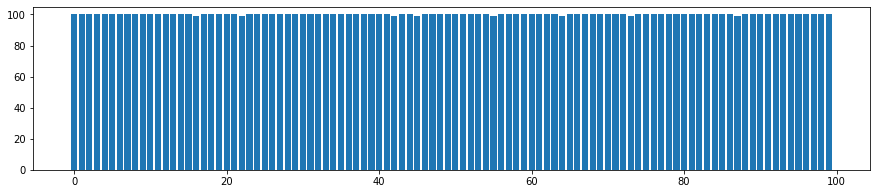

In [ ]:
rep_number = list( range( REPS_PER_TERRITORY ) )

fig, ax = plt.subplots(1, 1) 
fig.set_size_inches(15, 3)
ax.bar( x=rep_number , height=unique_cultures_beginning )

<BarContainer object of 100 artists>

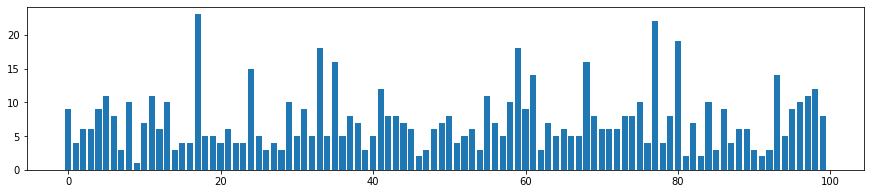

In [ ]:
fig, ax = plt.subplots(1, 1) 
fig.set_size_inches(15, 3)
ax.bar( x=rep_number , height=unique_cultures_end )


In [ ]:
print('Average of the number of unique cultures in the beginning:' ,
      unique_cultures_beginning.mean() , 
      'and in the end:' , unique_cultures_end.mean() ) 

Average of the number of unique cultures in the beginning: 99.92 and in the end: 7.3
